#### Sequence Length in Embedding Space

In [145]:
cd ..

/home/romi/projects


In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os, sys
import collections
import importlib
import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import anndata as ad
import scanpy as sc

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)

from cvc import model_utils
from cvc import plot_utils
from cvc import utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

#### Load data

In [150]:
data_dir = DATA_DIR + "db_data_nuc_vj_genes_pub_priv.csv"

In [151]:
# load data db
tcrb_data = pd.read_csv(data_dir, usecols=["Sequences", "Private_Public_label"], engine="pyarrow")

# drop duplicates
tcrb_data_sample_from = tcrb_data.drop_duplicates()
tcrb_data_sample_from.head()

,Sequences,Private_Public_label
0,CASSLGETQYF,1
16658,CASSLGYEQYF,1
30397,CASSLGGNTEAFF,1
43085,CASSSSYEQYF,1
54734,CASSLQETQYF,1


In [152]:
len(tcrb_data)

91758697

#### Add Columns: Length and Percentile

In [157]:
# add column of sequence lengths
tcrb_data_sample_from['Length'] = tcrb_data_sample_from['Sequences'].apply(len)

# divide Lengths to bins
# tcrb_data_sample_from["Length_bin"] = pd.cut(
#     tcrb_data_sample_from["Length"], bins=[0, 10, 12, 14, 16, 18, 20, 22, 24, 40], labels=[
#         "0-10", "11-12", "13-14", "15-16", "17-18", "19-20", "21-22", "23-24", "25-40"]
# )

# determine the quartile values to use with pd.cut
quartiles = tcrb_data_sample_from['Length'].quantile([.1, .25, .5, .75, .9]).tolist()

# add a lower and upper range for the bins in pd.cut
quartiles = [0] + quartiles + [float('inf')]

# add a quartiles column of the lengths
tcrb_data_sample_from['Percentile'] = pd.cut(tcrb_data_sample_from['Length'], bins=quartiles,
                                             labels=['0-10%', '10-25%', '25-50%', '50-75%', '75-90%', '90-100%'])

In [158]:
# get percentile fractions counts
tcrb_data_sample_from.Percentile.value_counts()

25-50%     21696931
50-75%     18218306
75-90%     16118955
10-25%     16028358
0-10%      15495385
90-100%     4200762
Name: Percentile, dtype: int64

In [159]:
# get percentile fractions
tcrb_data_sample_from['Percentile'].value_counts(normalize=True)

25-50%     0.236456
50-75%     0.198546
75-90%     0.175667
10-25%     0.174679
0-10%      0.168871
90-100%    0.045781
Name: Percentile, dtype: float64

In [160]:
quartiles

[0, 13.0, 14.0, 15.0, 16.0, 18.0, inf]

In [165]:
# Resamples data into df_counts_small
total_amount_seq = 1000000
# df_counts_small will contain 10% of the data from df_counts for each group by CR_num
def filter_data(df):
    if len(df) > 20_000_000:
        return df.sample(n=int(0.23*total_amount_seq))
    elif len(df) > 16_000_000:
        return df.sample(n=int(0.20*total_amount_seq))
    elif len(df) > 14_000_000:
        return df.sample(n=int(0.17*total_amount_seq))
    elif len(df) > 4_000_000:
        return df.sample(n=int(0.05*total_amount_seq))
    else:
        return df

tcrb_data_sample = tcrb_data_sample_from.groupby('Percentile').apply(filter_data)
tcrb_data_sample.Percentile.value_counts()

25-50%     230000
10-25%     200000
50-75%     200000
75-90%     200000
0-10%      170000
90-100%     50000
Name: Percentile, dtype: int64

In [164]:
# tcrb_data_sample = tcrb_data_sample_from  # To generate distribution on all data
tcrb_data_sample

,Sequences,Private_Public_label,Length,Percentile
0,CASSLGETQYF,1,11,0-10%
16658,CASSLGYEQYF,1,11,0-10%
30397,CASSLGGNTEAFF,1,13,0-10%
43085,CASSSSYEQYF,1,11,0-10%
54734,CASSLQETQYF,1,11,0-10%
...,...,...,...,...
199455315,CAWNAGTEANQPQHF,0,15,25-50%
199455316,CARGEGATLGGRVYFDYW,0,18,75-90%
199455317,CASSVHRLRTEAFF,0,14,10-25%
199455318,CSASTTERGNTDTQYF,0,16,50-75%


#### Color Normal Distribution by Percentile

In [122]:
# make color array by Percentile column
all_lengths = (tcrb_data_sample['Length'].unique())
all_lengths.sort()
all_percentiles = [tcrb_data_sample[tcrb_data_sample['Length'] == length].Percentile.iloc[0] for length in all_lengths]
# get sns default hue palette
pal =sns.color_palette()
# get unique percentiles
unique_percentiles = np.unique(all_percentiles)
# give each unique percentile a color
color_idx_dict = {unique_percentiles[i]: i for i in range(len(unique_percentiles))}
# give all_percentiles a color from color_dict
colors_idx = [color_idx_dict[percentile] for percentile in all_percentiles]
colors = [pal[i] for i in colors_idx]
colors_hex = [matplotlib.colors.rgb2hex(color) for color in colors]

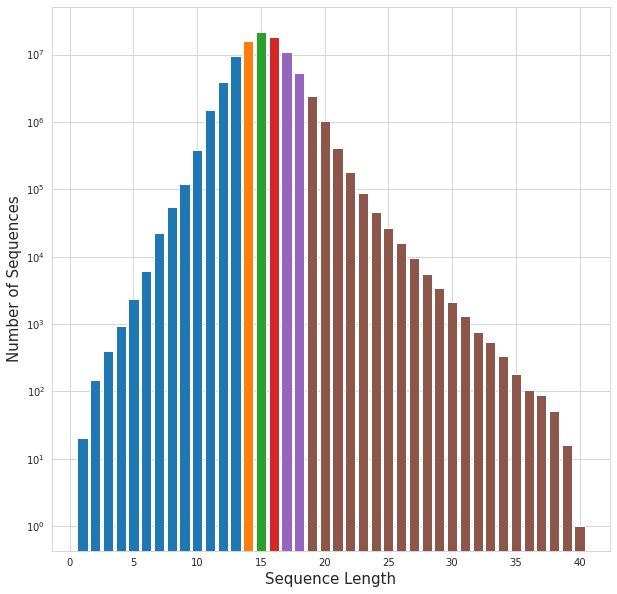

In [141]:
fig, ax = plt.subplots(figsize=(10, 10))
# Bar Plot
x = collections.Counter(tcrb_data_sample['Length']).keys()
y = collections.Counter(tcrb_data_sample['Length']).values()
# sort x and y by x
x, y = zip(*sorted(zip(x, y)))

plt.bar(x, y, color=colors_hex)
# put y axis in log scale
plt.yscale('log')
plt.xlabel("Sequence Length", fontsize=15)
plt.ylabel('Number of Sequences', fontsize=15)
# Show Plot
plt.show()

In [ ]:
# # add column with sequence lengths divided into bins ([4-11],[12-17],[18-38])
# tcrb_data_sample['Sequences_Length_Bins'] = tcrb_data_sample['Sequences_Length'].apply(lambda x: 'Smaller than 12' if x <=11 else '12-17' if x > 11 and x <=17 else '18 and above')
# tcrb_data_sample

In [22]:
len(collections.Counter(tcrb_data_sample['Length']))

37

#### Create and Display embeddings

In [ ]:
from cvc.embbeding_wrapper import EmbeddingWrapper

# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, tcrb_data_sample, batch_size=1024, method="mean", layers=[-1])
embed_wrap.embeddings.shape

In [ ]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()

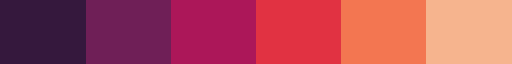

In [167]:
# Create colormap of 16 shades of blues
color_map = ListedColormap(sns.color_palette("rocket", 6))
color_map

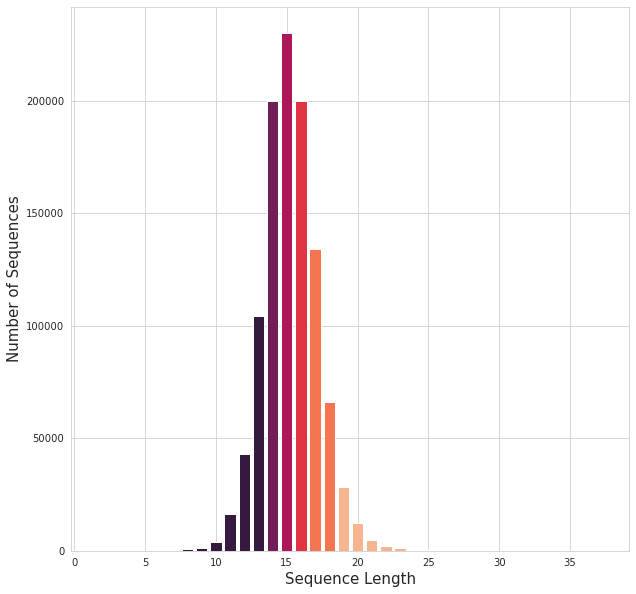

In [169]:
# Generate Normal Distribution with UMAP colors

# make color array by Percentile column
all_lengths = (tcrb_data_sample['Length'].unique())
all_lengths.sort()
all_percentiles = [tcrb_data_sample[tcrb_data_sample['Length'] == length].Percentile.iloc[0] for length in all_lengths]
# get sns default hue palette
pal =sns.color_palette("rocket", 6)
# get unique percentiles
unique_percentiles = np.unique(all_percentiles)
# give each unique percentile a color
color_idx_dict = {unique_percentiles[i]: i for i in range(len(unique_percentiles))}
# give all_percentiles a color from color_dict
colors_idx = [color_idx_dict[percentile] for percentile in all_percentiles]
colors = [pal[i] for i in colors_idx]
colors_hex = [matplotlib.colors.rgb2hex(color) for color in colors]
fig, ax = plt.subplots(figsize=(10, 10))
# Bar Plot
x = collections.Counter(tcrb_data_sample['Length']).keys()
y = collections.Counter(tcrb_data_sample['Length']).values()
# sort x and y by x
x, y = zip(*sorted(zip(x, y)))

plt.bar(x, y, color=colors_hex)
# put y axis in log scale
# plt.yscale('log')
plt.xlabel("Sequence Length", fontsize=15)
plt.ylabel('Number of Sequences', fontsize=15)
# Show Plot
plt.show()

In [ ]:
# to display by private/public label make flag equal to 1
DISPLAY_PUB_PRIV = 1

if DISPLAY_PUB_PRIV == 1:
    color_label = 'Private_Public_label'
    title = "UMAP of Embeddings, Colored by Public/Private Label"
    colors = ['gold', 'darkblue']
    cmap_colors = matplotlib.colors.ListedColormap(colors)
    pdf_title = "umap_sequence_length_pub_priv.pdf"
else:
    color_label = 'Percentile'
    title = "UMAP of Embeddings, Colored by Sequence Lengths Percentiles",
    cmap_colors = color_map
    pdf_title = "umap_sequence_length.pdf"

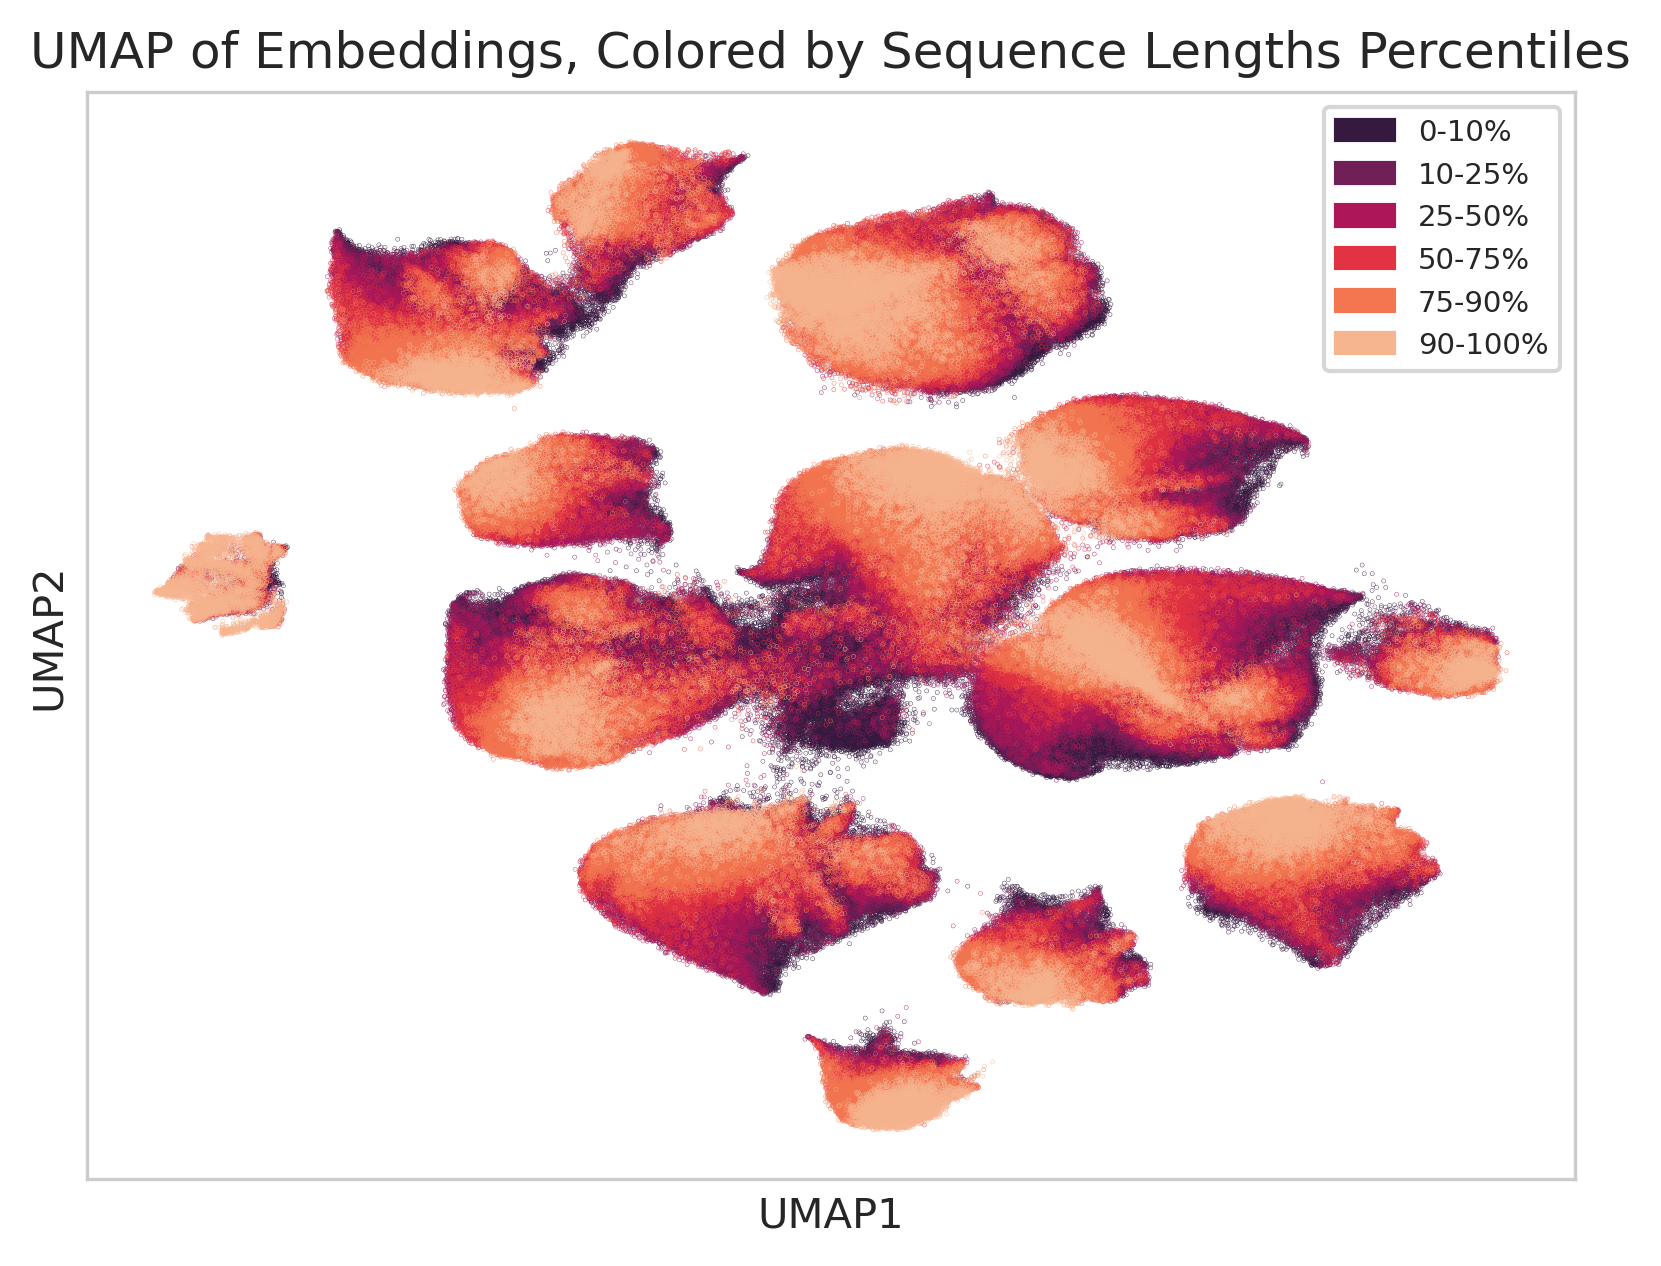

In [39]:
# Plot embeddings
importlib.reload(plot_utils)
embed_wrap.plot_embedding(
    color_embed=color_label,
    color_map=cmap_colors,
    title=title,
    legend_size=7,
    plot_pdf_path=os.path.join(PLOT_DIR, pdf_title),
)